## First look at Sentinel-6 sea surface height anomalies data ##

Look at Sentinel-6 data

<br>made for Eumetsat Copernicus Marine Data Service by V. Rosmorduc, CLS

** Import libraries **

In [2]:
# to interpret paths and folder for any OS
import os
import glob
# math library
import numpy
# reading /using NetCDF data
import xarray
# plotting library
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
#remove warnings for ease of reading
import warnings
warnings.filterwarnings('ignore')

#we will look at the plot within the notebooks
%matplotlib inline

global plot 

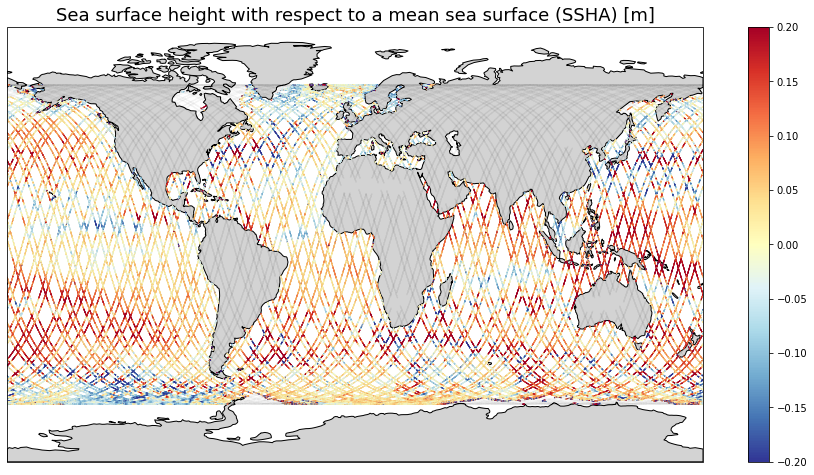

In [13]:
input_root = 'data/'
#we retrieved a full S6 cycle, unzipped the files and put all the "RED" files in the same folder to save on opening time
input_path = 'S6_cycle054/'
input_file = 'S6A_P4_2__HR_RED_*.nc'

s6_files= glob.glob(os.path.join(input_root,input_path,input_file))
if s6_files != []:
    s6cycle01 = xarray.open_mfdataset(s6_files, group='data_01', combine='nested', concat_dim='time')
    s6cycle01ku = xarray.open_mfdataset(s6_files, group='data_01/ku', combine='nested', concat_dim='time')
else:
    print('no files found')

# we will be plotting latitude, longitude and pre-computed SSHA
lat = s6cycle01['latitude']
lon = s6cycle01['longitude']
ssha = s6cycle01ku['ssha']

#plot on a world map
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
# actually plot the data
tracks = ax.scatter(lon, lat, c=ssha, vmin=-0.2, vmax=0.2, cmap='RdYlBu_r', marker='o', s=1, edgecolors='black', linewidth=0.001)
cbar = plt.colorbar(tracks)
plt.title('Sea surface height with respect to a mean sea surface (SSHA) [m]', size=18)
plt.show()

You'll notice that SSHA is not available on land, nor in some sea-ice regions -- the computation of SSHA in itself ensure this. If you look at the "comment" of this variables, you will read:
= altitude of satellite (/data_01/altitude) - Ku band corrected altimeter range (range_ocean) - filtered altimeter ionospheric correction on Ku band (iono_cor_alt_filtered) - model dry tropospheric correction (/data_01/model_dry_tropo_cor_zero_altitude) - radiometer wet tropospheric correction (/data_01/rad_wet_tropo_cor) - sea state bias correction in Ku band (sea_state_bias) - solid earth tide height (/data_01/solid_earth_tide) - geocentric ocean tide height from FES solution (/data_01/ocean_tide_fes) - non-equilibrium long-period ocean tide height (/data_01/ocean_tide_non_eq) - geocentric pole tide height (/data_01/pole_tide) - internal tide (/data_01/internal_tide) - dynamic atmospheric correction (/data_01/dac) - mean sea surface from CNES/CLS solution (/data_01/mean_sea_surface_cnescls). Set to default if the waveform classification (wvf_main_class) is not set to 1 = brown ocean, 12 = shifted brown, 13 = brown noise leading edge or 15 = linear positive_slope, the radiometer surface type (/data_01/rad_surface_type_flag) set to 2 = land

The latter sentence means that you are only above ocean or large bodies of ice-free water. 

### Extraction over an area - ###
notice that up till now, we have plotted one variable with respect to two others which are not in the same Xarray dataset. We can do it because the indexes are strictly the same. However it is a very limited way of using the data. We will create a dataset combining all the extracted variables so as to be able to really use them in relation.

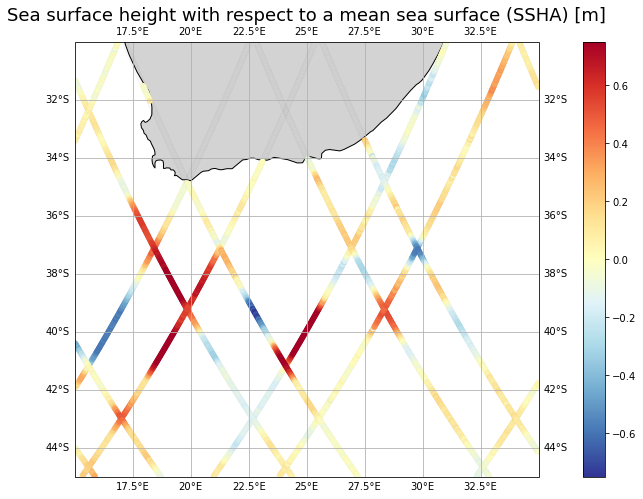

In [14]:
#area limits
lon_min=15 ; lon_max=35 ; lat_min=-45 ; lat_max=-30
# reasonable SLA min/max in the area.
hmin = -0.75 ; hmax = 0.75

lat = s6cycle01['latitude']
lon = s6cycle01['longitude']
ssha = s6cycle01ku['ssha']

# merge the lon, lat and the ssha variable in the same dataset to be able to select the one wrt the others
ds = xarray.Dataset({'ssha01': (['time'],  ssha.data)}, coords={'lon01': (['time'], lon.data), 'lat01': (['time'], lat.data)})
s6cycle01.close()
s6cycle01ku.close()

# extract only the area of interest. We will use only this dataset after.
extr = ds.sel(time=( ds.lon01 > lon_min) & (ds.lon01 < lon_max) & (ds.lat01 > lat_min) & (ds.lat01 < lat_max))
slaextr = extr['ssha01']
lonextr = extr['lon01']
latextr = extr['lat01']
ds.close()

# plot the extracted data
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.gridlines(draw_labels = True)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
# actually plot the data
tracks = ax.scatter(lonextr, latextr, c=slaextr, vmin=hmin, vmax=hmax, cmap='RdYlBu_r', marker='o', edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
plt.title('Sea surface height with respect to a mean sea surface (SSHA) [m]', size=18)
plt.show()


You see in dark red the warm eddies ("hills") overflown by the altimeter, and in blue the cold ones detected along the whole 10 days of the Sentinel-6 cycle. In an energetic current such as this one, in ten days the eddies should have moved noticeably.